
# Preprocessing for Segmentation Model

## 1. Preparations
### 1.1 Install required packages

**!!! ATTENTION !!!**    
Select right Kernel/Environment (with PyTorch installed): `pytorch_env_pyth311`

In [46]:
# check current python version and environment
!python --version
!where python 

Python 3.11.11
c:\Users\simon\anaconda3\envs\pytorch_env_pyth311\python.exe
C:\Users\simon\AppData\Local\Microsoft\WindowsApps\python.exe


In [47]:
# import required packages
import json
import os
import geopandas as gpd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch

In [48]:
# !pip install segmentation-models-pytorch

In [49]:
# import segmentation models module
import segmentation_models_pytorch as smp

### 1.2 Load data

In [50]:
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
# npy patches
patches_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\patches'
# JSON class codes
codes_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\classes'
# Shapefile class labels
labels_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles'

In [51]:
# Class labels
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [52]:
# Class codes
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [53]:
# Test patch

## 2. Choose segmentation model

In [54]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

## 3. Configure data preprocessing

Datenvorverarbeitungsfunktion (preprocess_input) für ein bestimmtes Modell (Encoder) konfigurieren:

`from segmentation_models_pytorch.encoders import get_preprocessing_fn`

`preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')`

Encoder = der Teil des neuronalen Netzes, der Features aus den Eingabedaten extrahiert (in diesem Fall das vortrainiertes Modell "resnet" auf ImageNet)
Pretraining = Encoder bereits auf einem großen Datensatz (z. B. ImageNet) trainiert > kann nützliche feature erkennen

Warum Datenvorverarbeitung nötig ist:
- Während des Trainings der vortrainierten Gewichte (z. B. auf ImageNet) wurde eine spezifische Vorverarbeitung auf die Bilder angewendet, z. B. Normalisierung, Größenanpassung oder Farbraumkonvertierung.
- Um die bestmögliche Leistung mit den vortrainierten Gewichten zu erzielen, sollten die Eingabedaten genauso vorverarbeitet werden, wie es während des Pretrainings gemacht wurde.

Was `get_preprocessing_fn` macht:
Diese Funktion liefert eine Vorverarbeitungsfunktion (preprocess_input), die genau die gleichen Transformationen durchführt, die während des Pretrainings auf den ImageNet-Datensatz angewendet wurden.





In [55]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet') # load specific (suitable to chosen model) preprocessing function

In [56]:
# create output directory for preprocessed patches
preprocessed_patches_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\preprocessed_patches'
if not os.path.exists(preprocessed_patches_dir):
    os.makedirs(preprocessed_patches_dir)

In [57]:
patches_list = [f for f in os.listdir(patches_dir) if not f.endswith('_mask.npy')]  # list of all patches (not the masks)
patches_list.sort() # sort list alphabetically
# patches_list

In [ ]:
# PREPROCESSING LOOP

for idx, patch_name in enumerate(patches_list): # iterate over all patches
    patch_path = os.path.join(patches_dir, patch_name)  # path to specific patch
    patch = np.load(patch_path, allow_pickle= True)  # load npy file as dictionary object (allow pickle = True)
    image_data = patch.item().get('image')   # extract image key from dictionary

    # print(f"Processing patch {idx + 1}/{len(patches_list)}: {patch_name}")
    # print(image_data.shape)

    # check if image has the right shape: [height, width, color channels]
    if image_data.shape[0] in [1, 3]:  # shape is: [C, H, W]
        image_data = image_data.transpose(1, 2, 0)  # [H, W, C]
    # print(image_data.shape)

    # use the preprocessing function
    preprocessed_image_data = preprocess_input(image_data)

    # transpose back to [C, H, W]
    preprocessed_image_data = preprocessed_image_data.transpose(2, 0, 1)

    # save preprocessed patch
    output_path = os.path.join(preprocessed_patches_dir, patch_name)
    np.save(output_path, preprocessed_image_data)

    # display progress
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(patches_list)} patches")

Processed 0/11173 patches
Processed 100/11173 patches
Processed 200/11173 patches
Processed 300/11173 patches
Processed 400/11173 patches
Processed 500/11173 patches
Processed 600/11173 patches
Processed 700/11173 patches
Processed 800/11173 patches
Processed 900/11173 patches
Processed 1000/11173 patches
Processed 1100/11173 patches


Check if preprocessing works!

In [ ]:
SECTION = "A01"
TEST_PATCH_ID = 197 # -------------------->> ADJUSTABLE

In [ ]:
# preprocessed patch path
preprocessed_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (NO DICTIONARY ANYMORE)
preprocessed_patch = np.load(preprocessed_patch_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


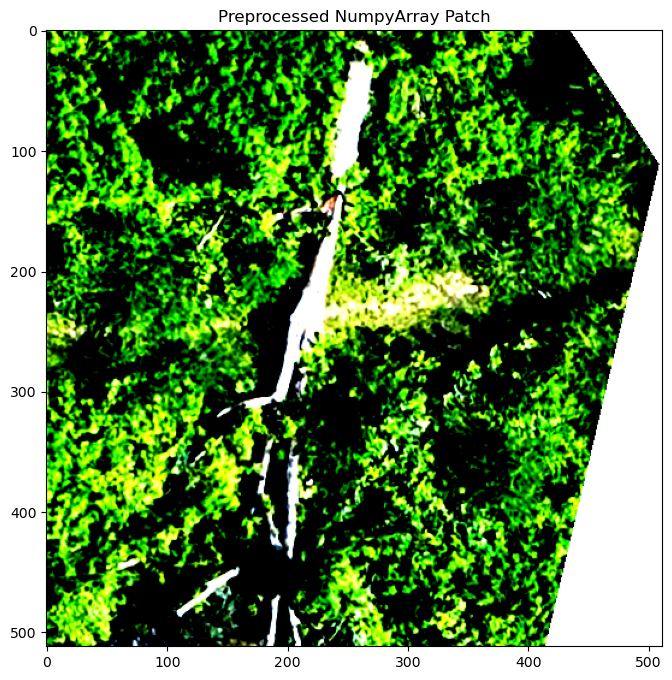

In [ ]:
# plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(preprocessed_patch.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed NumpyArray Patch")
plt.show()